In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from IPython import display



# dataset indirimi 28 x 28 lik imageler

In [24]:

# Veri indirme ve transformasyon işlemleri
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

# Veri yükleyicisi oluşturma
batch_size = 128
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False)


In [25]:
sample=train_dataset[0]
image,label=sample
image.shape

torch.Size([1, 28, 28])

In [26]:
len(train_dataset)


60000

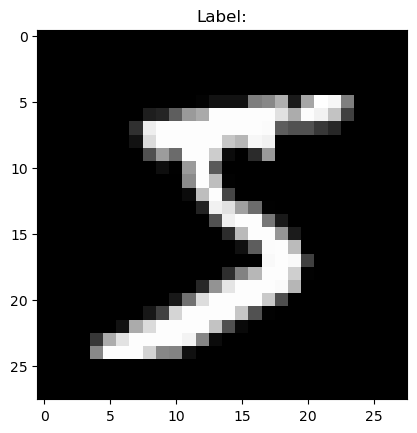

In [27]:
sample = train_dataset[0]
image, label = sample
#image tensörlerini numpy a çevirmemiz gerekiyor.
image = image.numpy()
plt.imshow(image[0], cmap='gray')
plt.title("Label:".format(label))
plt.show()

# Dataseti inceleyelim

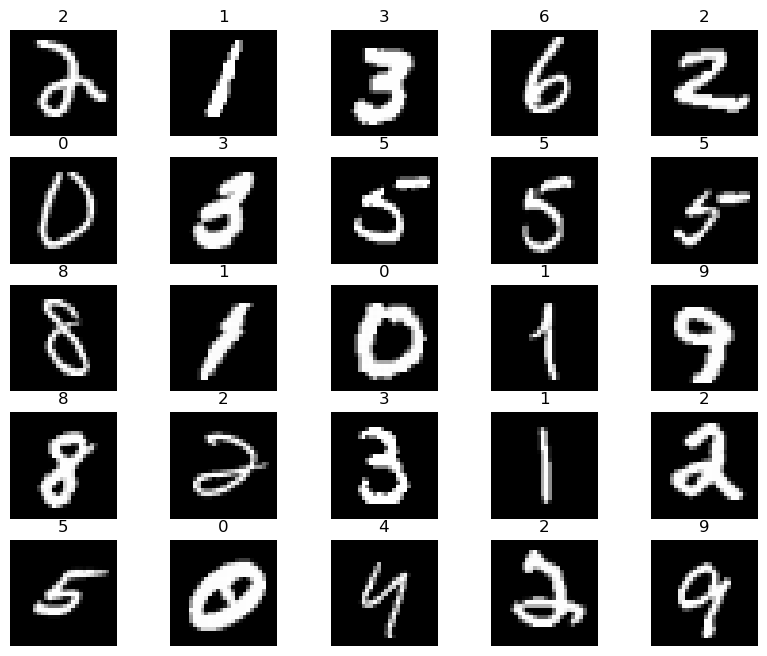

In [28]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [29]:
image[0].shape

(28, 28)

In [30]:
label

9

# cnn modeli

In [45]:
#model tanımı
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)#input layer
        self.relu1 = nn.ReLU()#activation function
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)#layer
        self.relu2 = nn.ReLU()#activation function
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(7*7*64, 20)#output layer # 28x28 = 7*4*7*4=> görüntüyü 2x2 piksel parçalarına ayırarak 64 adet parçaya bölerek çıktı boyutu 20
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = CNN()


# model eğitimi

In [46]:
learning_rate = 0.001
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/5, Loss: 0.2333
Epoch 2/5, Loss: 0.0595
Epoch 3/5, Loss: 0.0423
Epoch 4/5, Loss: 0.0330
Epoch 5/5, Loss: 0.0266


In [49]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
import itertools

# model test edilmesi

Accuracy: 0.99


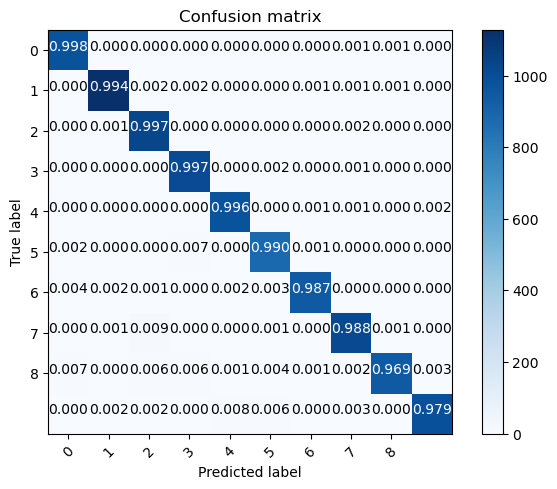

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


accuracy = 0
total = 0
predictions = []
true_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        
        outputs = model(images)
        max_value, max_index = torch.max(outputs.data, 1)
        predicted_labels = max_index
        
       
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())
        
        correct_predictions = (predicted_labels == labels)
        accuracy += correct_predictions.sum().item()
        total += len(correct_predictions)


accuracy = accuracy / total
print(f'Accuracy: {accuracy:.2f}')



conf_matrix = confusion_matrix(true_labels, predictions)


plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, f'{conf_matrix[i, j]:.3f}',
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# rnn model yaratımı

In [51]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0))
        out = self.fc(out[:, -1, :])
        return out
        
model = RNN(input_size=28, hidden_size=128, num_layers=2, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




# model eğitimi

In [52]:
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28, 28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/5, Loss: 0.7760
Epoch 2/5, Loss: 0.3034
Epoch 3/5, Loss: 0.2046
Epoch 4/5, Loss: 0.1569
Epoch 5/5, Loss: 0.1320


# model test edilmesi

Accuracy: 0.9648


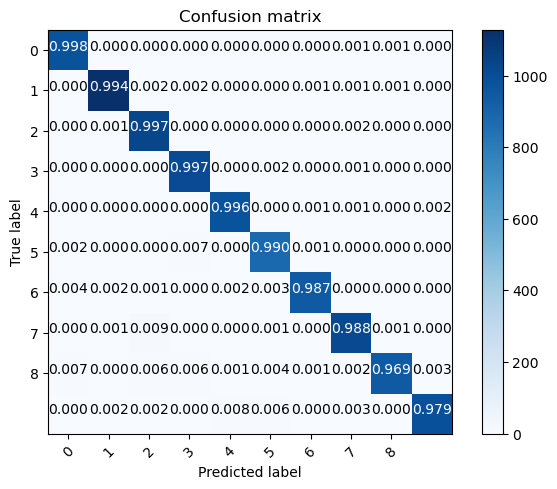

In [53]:

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # resimleri 28x28 olacak şekilde düzenliyoruz
        images = images.view(-1, 28, 28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
    # accuracy hesaplanması:
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

conf_matrix = confusion_matrix(true_labels, predictions)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, f'{conf_matrix[i, j]:.3f}',
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()#v


In [54]:
sample = next(iter(test_loader))
imgs, lbls = sample

## test edilme örneği

In [55]:
test_output = model(imgs[:200].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:200].numpy()
print(f"Predicted number: {predicted}")
print(f"Actual number: {labels}")
predicted-labels

Predicted number: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 4 9 0 5]
Actual number: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5]


array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -3,  0,  0,  0], dtype=int64)

# lstm

In [56]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        
model = LSTM(input_size=28, hidden_size=128, num_layers=2, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# model eğitimi 

In [57]:
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28, 28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/5, Loss: 0.5576
Epoch 2/5, Loss: 0.1342
Epoch 3/5, Loss: 0.0861
Epoch 4/5, Loss: 0.0646
Epoch 5/5, Loss: 0.0522


# model test edilmesi

Accuracy: 0.9777


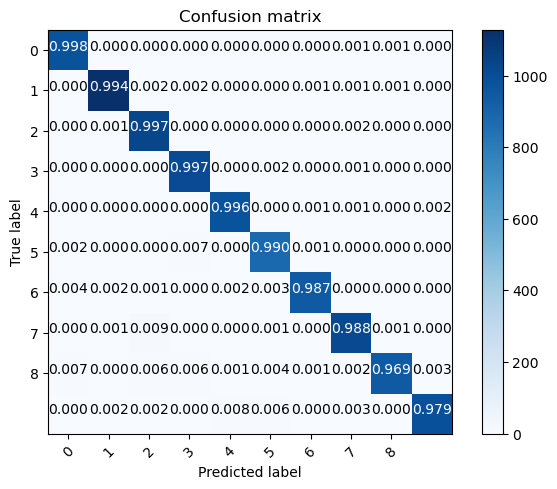

In [58]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28, 28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct/total:.4f}')
conf_matrix = confusion_matrix(true_labels, predictions)

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, f'{conf_matrix[i, j]:.3f}',
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()#v